# Spot or bin resolutions

Our main tutorials focus on imaging-based technologies such as Xenium or MERSCOPE data. Still, you can use Novae on NGS-based technologies such as Visium or Visium HD data. Since the resolution is highly different, we split this tutorial into two main sections: one for Visium-like technologies, and one for VisiumHD-like technologies.

## Visium data

We don't have **yet** a foundation model for spot-based technologies. This may be added in the future.

Meanwhile, you can train a Novae model on your dataset. Since Visium datasets have a relatively low number of spots (usually less than 100,000 spots), training a new Novae model is very fast.


## Visium HD usage

For technologies with small bins such as VisiumHD data, you have two possibilities: you can either work on the cells themselves, or on the bins.

### 1. Going at the single-cell resolution

You can also use this [Visium HD tutorial](https://gustaveroussy.github.io/sopa/tutorials/visium_hd/) from Sopa to segment cells on the H&E image and then aggregate the 2um bins inside the cells. This way, you'll have a single-cell resolution table, similar to what we get with Xenium or MERSCOPE data.

Then, based on this single-cell table, you can follow the ["normal usage" tutorial](../main_usage).


### 2. Using the 8um bins

You can use [spatialdata_io](https://spatialdata.scverse.org/projects/io/en/latest/generated/spatialdata_io.visium_hd.html) to read the output of SpaceRanger, it will create a SpatialData object containing multiple `AnnData` objects for the bins. You can simply use the `AnnData` corresponding to the 8um bins, which is the one that is the closest to a typical cell size.

Then, you can use a pre-trained model (in zero-shot or fine-tuning as in the other tutorial), but since the nature of the data is different, you can also re-train a model like below.

> For more customization, like using a GPU, you can look at the [API](../../api/Novae) or the [FAQ](../../faq).


In [ ]:
import spatialdata_io

# open the output of Space Ranger as a spatialdata object
sdata = spatialdata_io.visium_hd("/path/to/spaceranger_output_dir")

# get the AnnData object corresponding to the 8 microns bins
adata = sdata["square_008um"]

# you can optionally pre-process the data, e.g. removing the bins with no counts

For the sake of this tutorial, we'll directly load the 8um data table from the Novae database:


In [1]:
import novae
import scanpy as sc

In [2]:
adata = novae.utils.load_dataset(technology="visium_hd")[0]

[INFO] (novae.utils._data) Found 1 h5ad file(s) matching the filters.
/Users/quentinblampey/mambaforge/envs/novae/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


We can run some basic filtering, e.g. we remove the bins with less than 10 counts:


In [3]:
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=1_000)

/Users/quentinblampey/mambaforge/envs/novae/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Then, we create the graph of spatial neighbors. We specify `technology="visium_hd"` to use the grid structure of the 8um bins.


In [4]:
novae.utils.spatial_neighbors(adata, technology="visium_hd")

[INFO] (novae.utils._build) Computing graph on 600,414 cells (coord_type=grid, delaunay=False, radius=None, n_neighs=8)


We see that the graph is highly connected, except for some regions on the right:


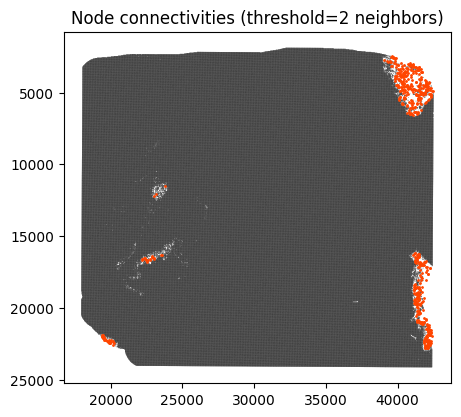

In [5]:
novae.plot.connectivities(adata)

In [6]:
model = novae.Novae(adata)
model

[INFO] (novae.utils._validate) Preprocessed 1 adata object(s) with sc.pp.normalize_total and sc.pp.log1p (raw counts were saved in adata.layers['counts'])
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[INFO] (novae.module.embed) Running PCA embedding initialization


Novae model
   ├── Known genes: 672
   ├── Parameters: 573.7K
   └── Model name: None

In [7]:
model.fit(max_epochs=10)  # or more epochs

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/quentinblampey/mambaforge/envs/novae/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | cell_embedder | CellEmbedder      | 77.3 K | train
1 | encoder       | GraphEncoder      | 430 K  | train
2 | augmentation  | GraphAugmentation | 0      | train
3 | swav_head     | SwavHead          | 65.5 K | train
------------------------------------------------------------
573 K     Trainable params
0         Non-trainable params
573 K     Total params
2.295     Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode
/Users/quentinblampey/mambaforge/envs/novae/lib/python3.10/site-packages/lightning/pytorch/trainer

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [8]:
model.compute_representations()
model.assign_domains(level=8)  # or more domains

Computing representations:   0%|          | 0/2344 [00:00<?, ?it/s]

'novae_domains_8'

[INFO] (novae.utils._validate) Using obs_key='novae_domains_8' by default.


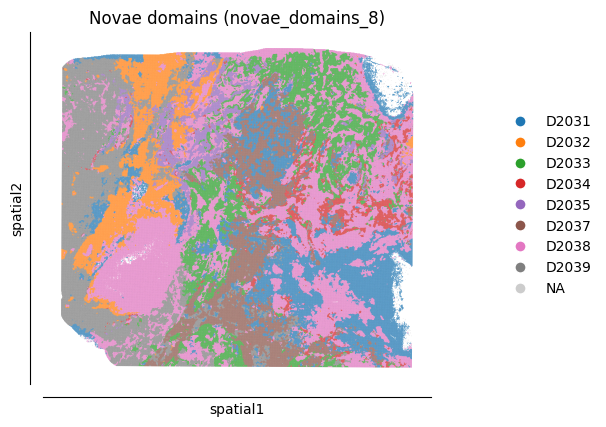

In [42]:
novae.plot.domains(adata, cell_size=35)